In [12]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

import numpy as np
import os
import pickle
import random
import matplotlib.pyplot as plt
import time

import importlib
import utils.ml_utils as ml_utils

## Set random seeds and make TF operate determinstically on GPU

In [2]:
# Make GPU use deterministic algorithms (see https://github.com/NVIDIA/tensorflow-determinism)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Seed value (can actually be different for each attribution step)
seed_value = 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

## Load data

In [3]:
# Constants
IMG_SIZE = 128 # All images in the dataset will be resized to this size
BATCH_SIZE = 32 # Batch size

In [4]:
# Read in training and validation data
train, validation = ml_utils.load_batched_and_resized_dataset(
    dataset_name='cats_and_dogs',
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE
)

Training Data Summary
No. of examples: 18610
Class: 0 :::: Count: 9378 :::: Percentage: 50.39226222461043
Class: 1 :::: Count: 9232 :::: Percentage: 49.60773777538957

Validation Data Summary
No. of examples: 4652
Class: 0 :::: Count: 2280 :::: Percentage: 49.011177987962164
Class: 1 :::: Count: 2372 :::: Percentage: 50.988822012037836


## Try baseline model

In [5]:
model = ml_utils.build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 4)       112       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 8)         296       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        4

In [6]:
# Start training
history = model.fit(
    train,
    epochs=10,
    validation_data=validation
)

Epoch 1/10
582/582 [==============================] - 32s 55ms/step - loss: 0.6919 - accuracy: 0.5435 - val_loss: 0.6902 - val_accuracy: 0.5969
Epoch 2/10
582/582 [==============================] - 12s 20ms/step - loss: 0.6876 - accuracy: 0.5814 - val_loss: 0.6833 - val_accuracy: 0.6172
Epoch 3/10
582/582 [==============================] - 12s 20ms/step - loss: 0.6780 - accuracy: 0.5912 - val_loss: 0.6652 - val_accuracy: 0.6258
Epoch 4/10
582/582 [==============================] - 12s 20ms/step - loss: 0.6653 - accuracy: 0.6035 - val_loss: 0.6481 - val_accuracy: 0.6371
Epoch 5/10
582/582 [==============================] - 12s 20ms/step - loss: 0.6532 - accuracy: 0.6171 - val_loss: 0.6350 - val_accuracy: 0.6472
Epoch 6/10
582/582 [==============================] - 12s 20ms/step - loss: 0.6402 - accuracy: 0.6359 - val_loss: 0.6225 - val_accuracy: 0.6565
Epoch 7/10
582/582 [==============================] - 12s 20ms/step - loss: 0.6249 - accuracy: 0.6519 - val_loss: 0.6064 - val_accuracy:

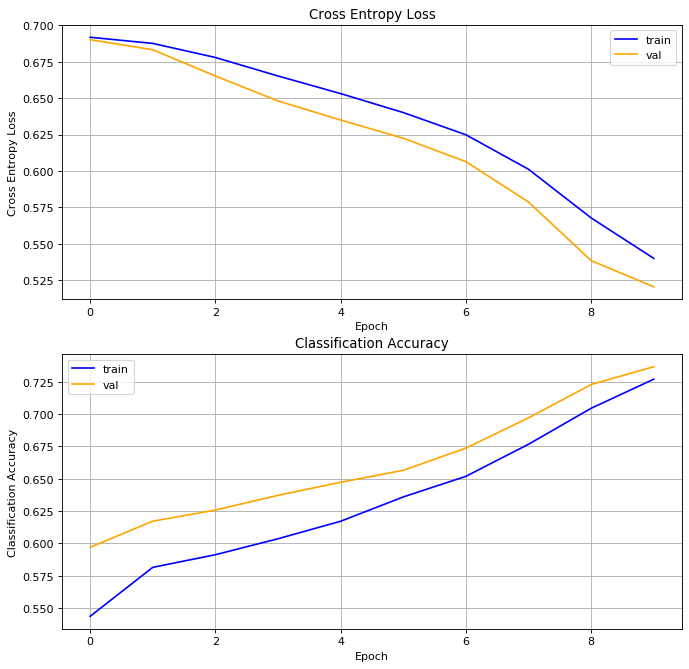

In [7]:
# Plot diagnostic learning curves
ml_utils.summarize_diagnostics(history)

## Identical runs

**tl;dr Results for identically-instantiated runs are identical.**

First, we perform a sanity check to ensure that multiple identical runs give the same result. Due to potential randomness from using the GPU/CuDNN, we need to set TF_DETERMINISTIC_OPS as indicated in https://github.com/NVIDIA/tensorflow-determinism. I checked that initialization weights and the order of the training data are the same across runs. Identical runs give identical results.

In [8]:
initialization_weights = []

for i in range(5):    
    # Build and train model
    model = ml_utils.build_model()
    initialization_weights.append([w.value() for w in model.weights])
    history = model.fit(
        train,
        epochs=1,
        validation_data=validation
    )

582/582 [==============================] - 13s 22ms/step - loss: 0.6919 - accuracy: 0.5435 - val_loss: 0.6902 - val_accuracy: 0.5969


In [11]:
# Check that initialization weights are the same
from functools import reduce

weights_equal = True

#Iterate through iterations
for i in range(4):
    curr_weights = initialization_weights[i]
    next_weights = initialization_weights[i+1]

    # Iterate through layers
    for j in range(len(curr_weights)):
        weights_equal &= tf.math.reduce_all(tf.math.equal(curr_weights[j], next_weights[j]))
print("Weights equal = ", weights_equal)

Weights equal =  tf.Tensor(True, shape=(), dtype=bool)


In [10]:
# Try using CPU
for i in range(5):
    with tf.device('/cpu:0'):
        model = ml_utils.build_model()
        history = model.fit(
            train,
            epochs=1,
            validation_data=validation
        )

582/582 [==============================] - 83s 142ms/step - loss: 0.6919 - accuracy: 0.5431 - val_loss: 0.6902 - val_accuracy: 0.5952


## Batch Size

In [13]:
batch_sizes = [1, 2, 8, 32, 128, 512, 2048]
batch_histories = {}
batch_training_times = {}

for batch_size in batch_sizes:
    # Read training data
    batch_train, batch_validation = ml_utils.load_batched_and_resized_dataset(
        dataset_name='cats_and_dogs',
        batch_size=batch_size,
        img_size=IMG_SIZE
    )

    # Build and train model
    model = ml_utils.build_model()
    start = time.time()
    history = model.fit(
        batch_train,
        epochs=10,
        validation_data=batch_validation,
    )
    batch_histories[batch_size] = history.history
    batch_training_times[batch_size] = time.time() - start

Training Data Summary
No. of examples: 18610
Class: 0 :::: Count: 9378 :::: Percentage: 50.39226222461043
Class: 1 :::: Count: 9232 :::: Percentage: 49.60773777538957

Validation Data Summary
No. of examples: 4652
Class: 0 :::: Count: 2280 :::: Percentage: 49.011177987962164
Class: 1 :::: Count: 2372 :::: Percentage: 50.988822012037836
Epoch 1/10
18610/18610 [==============================] - 220s 12ms/step - loss: 0.6608 - accuracy: 0.5945 - val_loss: 0.6053 - val_accuracy: 0.7016
Epoch 2/10
18610/18610 [==============================] - 159s 9ms/step - loss: 0.5586 - accuracy: 0.7123 - val_loss: 0.5080 - val_accuracy: 0.7642
Epoch 3/10
18610/18610 [==============================] - 157s 8ms/step - loss: 0.4907 - accuracy: 0.7590 - val_loss: 0.4725 - val_accuracy: 0.7771
Epoch 4/10
18610/18610 [==============================] - 158s 8ms/step - loss: 0.4411 - accuracy: 0.7894 - val_loss: 0.4418 - val_accuracy: 0.7919
Epoch 5/10
18610/18610 [==============================] - 159s 9ms/st

146/146 [==============================] - 8s 54ms/step - loss: 0.6893 - accuracy: 0.5953 - val_loss: 0.6885 - val_accuracy: 0.6073
Epoch 6/10
146/146 [==============================] - 8s 54ms/step - loss: 0.6880 - accuracy: 0.5968 - val_loss: 0.6868 - val_accuracy: 0.6055
Epoch 7/10
146/146 [==============================] - 8s 55ms/step - loss: 0.6861 - accuracy: 0.5994 - val_loss: 0.6845 - val_accuracy: 0.6079
Epoch 8/10
146/146 [==============================] - 8s 54ms/step - loss: 0.6838 - accuracy: 0.6023 - val_loss: 0.6815 - val_accuracy: 0.6073
Epoch 9/10
146/146 [==============================] - 8s 54ms/step - loss: 0.6808 - accuracy: 0.6045 - val_loss: 0.6773 - val_accuracy: 0.6118
Epoch 10/10
146/146 [==============================] - 8s 54ms/step - loss: 0.6769 - accuracy: 0.6067 - val_loss: 0.6718 - val_accuracy: 0.6180
Training Data Summary
No. of examples: 18610
Class: 0 :::: Count: 9378 :::: Percentage: 50.39226222461043
Class: 1 :::: Count: 9232 :::: Percentage: 49.

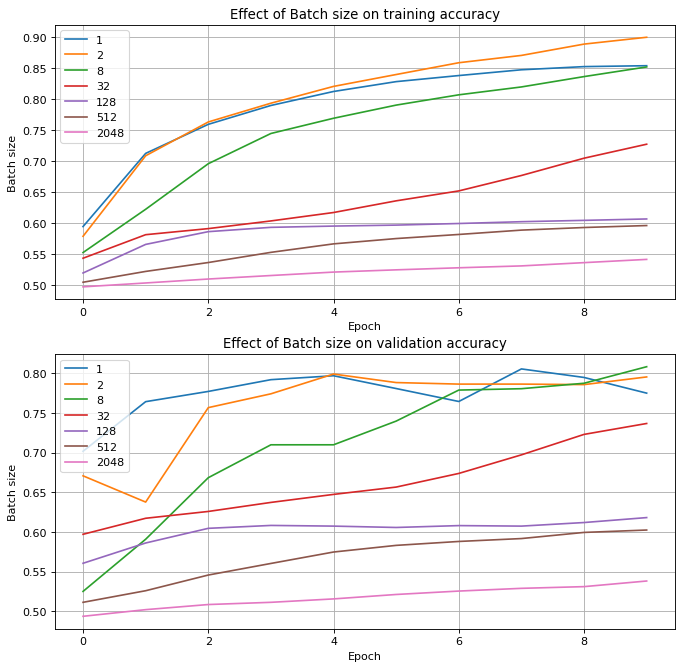

<Figure size 432x288 with 0 Axes>

In [14]:
ml_utils.plot_accuracies_by_param(batch_sizes, batch_histories, 'Batch size', 'batch_size_accuracies_2nd_try.png')

In [15]:
# Pickle the histories and the training times
pickle.dump(batch_histories, open("pickled_objects/batch_histories_2nd_try.pickle", "wb" ))
pickle.dump(batch_training_times, open("pickled_objects/batch_training_times_2nd_try.pickle", "wb"))

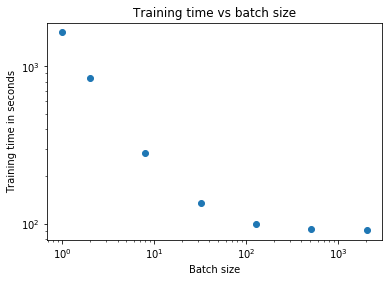

<Figure size 432x288 with 0 Axes>

In [29]:
# Plot and save training times
plt.plot(batch_sizes, [batch_training_times[b] for b in batch_sizes], 'o')
plt.xlabel('Batch size')
plt.ylabel('Training time in seconds')
plt.xscale('log')
plt.yscale('log')
plt.title('Training time vs batch size')
plt.show()
plt.savefig('graphs/batch_training_times_2nd_try.png')